In [1]:
import sys
dataset_folder = "../datasets"
sys.path.insert(0, "../")

In [2]:
from collections import defaultdict
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm

import datasets
import models
import video_transforms
import darknorm
from loss import CELoss

In [22]:
device = torch.device(0)
# using gpu 0
width = 170
height = 128
input_size = 112
length = 64

ckpt_location = 'checkpoints/gamma_ce_EE6222_DarkNormr18_split1_base'
dark_std = False

# ckpt_location = 'checkpoints/gamma_ce_EE6222_DarkNormr18_split1_base'
# dark_std = False

seed = 1234 # please check seed before continue
assert ('norm' in ckpt_location) == dark_std, 'mismatched dark_std'

In [23]:
def buildModel(model_path, num_categories, device, multiGPUTrain=True, multiGPUTest=False):
    model = models.__dict__['DarkNorm'](num_classes=num_categories, length=length)
    params = torch.load(model_path)

    if multiGPUTest:
        model = torch.nn.DataParallel(model)
        new_dict = {"module." + k: v for k, v in params['state_dict'].items()}
        model.load_state_dict(new_dict)

    elif multiGPUTrain:
        new_dict = {k[7:]: v for k, v in params['state_dict'].items()}
        model_dict = model.state_dict()
        model_dict.update(new_dict)
        model.load_state_dict(model_dict)
    else:
        model.load_state_dict(params['state_dict'])
    model.to(device)
    model.eval()
    return model

In [24]:
model_path = os.path.join('../', ckpt_location, 'model_best.pth.tar')
assert os.path.exists(model_path), 'model path not exist'

In [25]:
data_dir = os.path.join(dataset_folder, 'EE6222_frames')
extension = 'img_{0:05d}.jpg'
val_fileName = "val_split%d.txt" % 1

In [26]:
val_file = os.path.join(dataset_folder, 'settings', 'EE6222', val_fileName)

In [27]:
clip_mean_light = [0.485, 0.456, 0.406] * 1* length
clip_std_light = [0.229, 0.224, 0.225] * 1 * length
clip_mean = [0.0702773, 0.06571121, 0.06437492] * 1 * length
clip_std = [0.08475896, 0.08116068, 0.07479476] * 1 * length
if dark_std:
    normalize = video_transforms.Normalize(mean=clip_mean,
                                                   std=clip_std)
else:
    normalize = video_transforms.Normalize(mean=clip_mean_light,
                                           std=clip_std_light)
val_transform = video_transforms.Compose([
        video_transforms.CenterCrop((input_size)),
        video_transforms.ToTensor(),
        normalize,
    ])

criterion = CELoss().to(device)

In [28]:
val_dataset = datasets.EE6222(root=data_dir,
                              modality="rgb",
                              source=val_file,
                              phase="val",
                              is_color=True,
                              new_length=length,
                              new_width=width,
                              new_height=height,
                              video_transform=val_transform,
                              num_segments=1,
                              gamma=1.8,
                              method='gamma',
                              light=False)

In [29]:
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(seed)

val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=16, shuffle=False,
        num_workers=8, pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
)

In [30]:
model_start_time = time.time()
spatial_net = buildModel(model_path, 10, device)
model_end_time = time.time()
model_time = model_end_time - model_start_time
print("Action recognition model is loaded in %4.4f seconds." % (model_time))

Action recognition model is loaded in 1.6108 seconds.
Action recognition model is loaded in 1.6108 seconds.


In [31]:
# del features

In [32]:
features = defaultdict(list)
all_targets = list()
def getFeatures(name):
    # the hook signature
    def hook(model, input, output):
        # print(f"o: {output.shape}")
        f = output.detach().flatten(1).cpu()
        # print(f"f : {f.shape}")
        features[name].append(f)
    return hook
h = spatial_net.avgpool.register_forward_hook(getFeatures('avgpool'))

In [33]:
assert len(features['avgpool']) == 0
with torch.no_grad():
    for i, _input in enumerate(tqdm(val_loader)):
        (inputs, targets) = _input
        inputs = inputs.view(-1, length, 3, input_size,
                             input_size).transpose(1, 2)
        inputs = inputs.to(device)
        output = spatial_net(inputs)
        all_targets.append(targets)
h.remove()

100%|██████████| 20/20 [00:21<00:00,  1.09s/it]



In [34]:
features['avgpool'] = torch.concat(features['avgpool'])

In [35]:
features['label'] = torch.concat(all_targets)

In [36]:
feature_path = os.path.join('../', ckpt_location, 'val_features.pth')
torch.save(features, feature_path)

In [37]:
tsne_features = TSNE(n_components=2, perplexity=32,
                     n_iter=2000, method='exact',
                     learning_rate=50, random_state=seed).fit_transform(features['avgpool'])

/home/jiuntian/disk/miniconda3/envs/ee6222/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jiuntian/disk/miniconda3/envs/ee6222/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [38]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne_features[:, 0]
ty = tsne_features[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


saved as gamma_ce_EE6222_DarkNormr18_split1_base.pdf
saved as gamma_ce_EE6222_DarkNormr18_split1_base.pdf


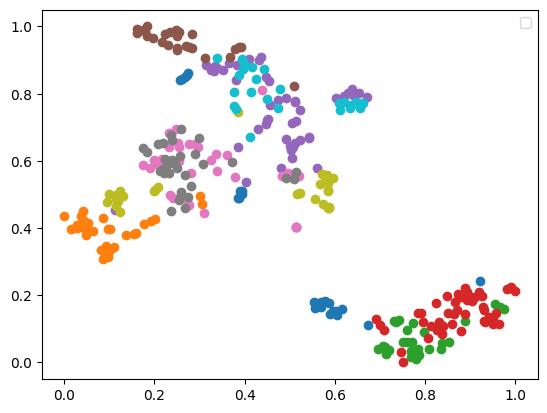

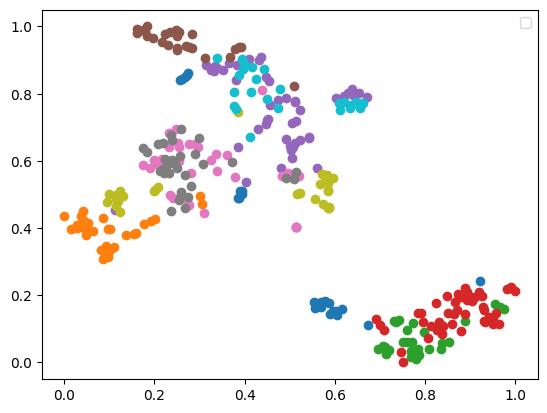

In [39]:
labels = features['label']
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in range(10):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    # color = np.array(colors_per_class[label], dtype=np.float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty)
 
 # build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
# plt.axis('off')
pdf_file_name = ckpt_location.split('/')[1] + ".pdf"
print(f"saved as {pdf_file_name}")
plt.savefig(pdf_file_name, bbox_inches='tight')
plt.show()